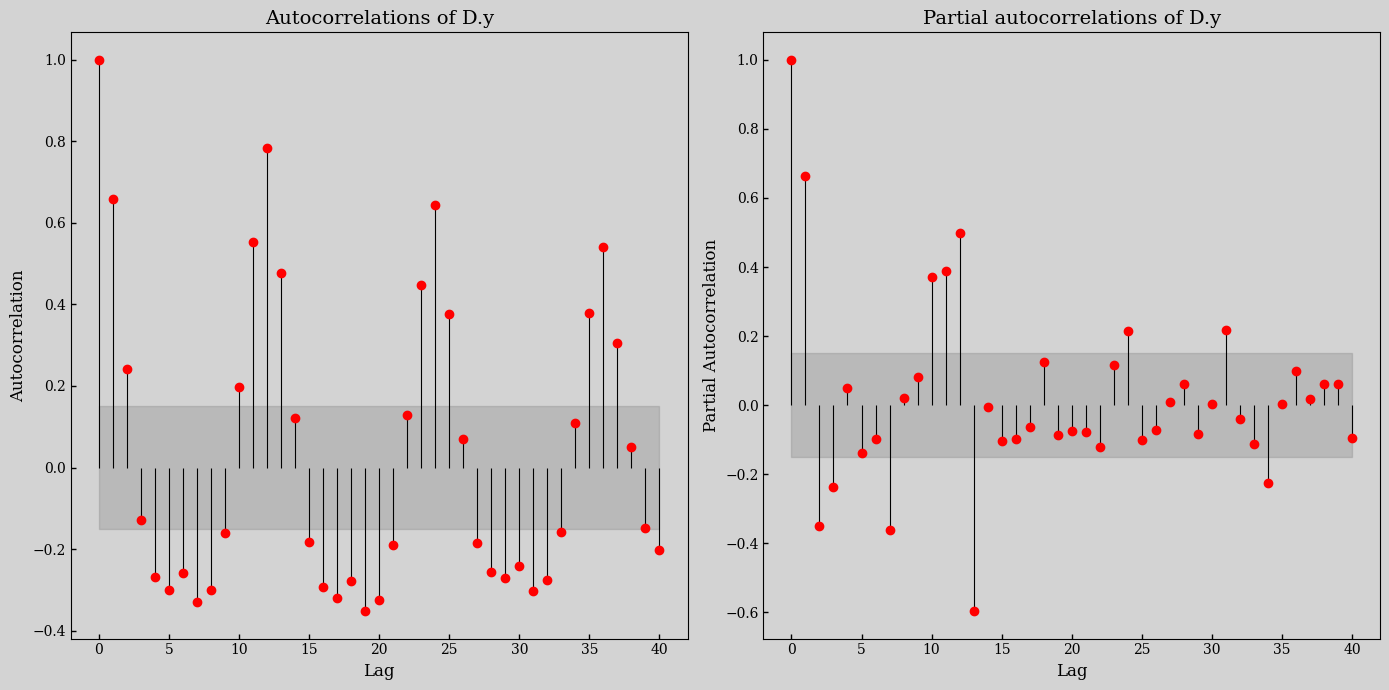

In [5]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product

# --- Wczytanie danych ---
file_path = "bezrobocie_czasowe.xlsx"
df = pd.read_excel(file_path)

if 'Data' in df.columns:
    df['Data'] = pd.to_datetime(df['Data'])
    y = df.set_index('Data')["Wartosc"].dropna()
    y = y.asfreq('MS')  # Zakładamy dane miesięczne – ustaw częstotliwość
else:
    y = df["Wartosc"].dropna()

# --- Konfiguracje ARIMA: p, d=1, q ---
model_configs = list(product([0, 1, 2, 3], [1], [0, 1, 2, 3]))

results = []

for config in model_configs:
    try:
        model = ARIMA(y, order=config).fit()
        aic = model.aic
        bic = model.bic
        hqic = model.hqic

        lb_test = acorr_ljungbox(model.resid, lags=[10], return_df=True)
        p_value_lb = lb_test["lb_pvalue"].iloc[0]

        results.append({
            "ARIMA(p,d,q)": config,
            "AIC": aic,
            "BIC": bic,
            "HQC": hqic,
            "Ljung-Box p-value": p_value_lb,
            "Log-Likelihood": model.llf
        })

    except Exception as e:
        print(f"Błąd dla modelu {config}: {e}")

# --- Wyniki jako DataFrame ---
df_results = pd.DataFrame(results).sort_values(by="AIC")

# --- Wyświetlenie najważniejszych kolumn ---
print("\n--- Porównanie modeli ARIMA(p,1,q) ---")
print(df_results[["ARIMA(p,d,q)", "AIC", "BIC", "HQC", "Ljung-Box p-value", "Log-Likelihood"]].to_string(index=False))


/Users/jakubwojna/Documents/ASC/python/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jakubwojna/Documents/ASC/python/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jakubwojna/Documents/ASC/python/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jakubwojna/Documents/ASC/python/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet


--- Porównanie modeli ARIMA(p,1,q) ---
ARIMA(p,d,q)         AIC         BIC         HQC  Ljung-Box p-value  Log-Likelihood
   (2, 1, 2) 4004.914744 4020.623062 4011.288511       9.999593e-01    -1997.457372
   (3, 1, 3) 4009.215729 4031.207374 4018.139002       9.999546e-01    -1997.607864
   (0, 1, 0) 4127.011374 4130.153037 4128.286127       9.918817e-01    -2062.505687
   (0, 1, 1) 4129.390975 4135.674302 4131.940482       9.990888e-01    -2062.695488
   (1, 1, 0) 4148.633482 4154.916809 4151.182988       9.991757e-01    -2072.316741
   (0, 1, 3) 4150.252816 4162.819470 4155.351830       9.996759e-01    -2071.126408
   (3, 1, 1) 4152.968400 4168.676717 4159.342166       9.999995e-01    -2071.484200
   (0, 1, 2) 4158.124569 4167.549559 4161.948829       9.993300e-01    -2076.062284
   (1, 1, 2) 4159.058634 4171.625288 4164.157647       9.994546e-01    -2075.529317
   (1, 1, 1) 4160.163041 4169.588031 4163.987301       9.991920e-01    -2077.081520
   (3, 1, 2) 4164.000202 4182.850184

In [43]:
import pandas as pd
import numpy as np
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import chi2
import warnings
warnings.filterwarnings("ignore")

# --- Wczytanie danych -------------------------------------------------------
file_path = "bezrobocie_czasowe.xlsx"   # ← podmień, jeśli plik w innej lokalizacji
df = pd.read_excel(file_path)

# jeżeli masz kolumnę z datami
if "Data" in df.columns:
    df["Data"] = pd.to_datetime(df["Data"])
    y = df.set_index("Data")["Wartosc"].dropna()
    y = y.asfreq("MS")                # zakładamy częstotliwość miesięczną
else:
    y = df["Wartosc"].dropna()

# --- Konfiguracje ARIMA: p,q ∈ {0,1,2,3}, d = 1 -----------------------------
model_configs = list(product(range(0, 3), [1], range(0, 5)))

results = []

# --- Petla po wszystkich konfiguracjach -------------------------------------
for (p, d, q) in model_configs:
    try:
        mdl = ARIMA(y, order=(p, d, q)).fit()

        # test Ljunga–Boxa (lag 10) dla reszt
        lb_p = acorr_ljungbox(mdl.resid, lags=[10], return_df=True)["lb_pvalue"].iloc[0]

        results.append({
            "model": f"ARIMA({p},{d},{q})",
            "p": p, "d": d, "q": q,
            "AIC": mdl.aic,
            "BIC": mdl.bic,
            "HQC": mdl.hqic,
            "logLik": mdl.llf,
            "LB_p(10)": lb_p
        })
    except Exception as err:
        # często modele z (p,q) wyższych rzędów mogą się nie zbiegać
        print(f"Model ARIMA({p},{d},{q}) nie zbiega się: {err}")

# --- Wyniki jako DataFrame ---------------------------------------------------
df_results = (
    pd.DataFrame(results)
      .sort_values("AIC")
      .reset_index(drop=True)
)

# --- Wyświetl podsumowanie ---------------------------------------------------
print("\n--- Porównanie modeli ARIMA(p,1,q) --- dla p ∈ {0,1,2}, d=1, q ∈ {0,1,2,3,4}")
cols = ["model", "AIC", "BIC", "HQC", "LB_p(10)", "logLik"]
print(df_results[cols].to_string(index=False))



--- Porównanie modeli ARIMA(p,1,q) --- dla p ∈ {0,1,2}, d=1, q ∈ {0,1,2,3,4}
       model         AIC         BIC         HQC     LB_p(10)       logLik
ARIMA(2,1,2) 4004.914744 4020.623062 4011.288511 9.999593e-01 -1997.457372
ARIMA(0,1,0) 4127.011374 4130.153037 4128.286127 9.918817e-01 -2062.505687
ARIMA(0,1,1) 4129.390975 4135.674302 4131.940482 9.990888e-01 -2062.695488
ARIMA(0,1,4) 4137.809721 4153.518039 4144.183488 9.999545e-01 -2063.904860
ARIMA(2,1,4) 4139.303209 4161.294854 4148.226482 9.976539e-01 -2062.651604
ARIMA(1,1,0) 4148.633482 4154.916809 4151.182988 9.991757e-01 -2072.316741
ARIMA(1,1,4) 4148.885661 4167.735642 4156.534181 9.999994e-01 -2068.442830
ARIMA(0,1,3) 4150.252816 4162.819470 4155.351830 9.996759e-01 -2071.126408
ARIMA(0,1,2) 4158.124569 4167.549559 4161.948829 9.993300e-01 -2076.062284
ARIMA(1,1,2) 4159.058634 4171.625288 4164.157647 9.994546e-01 -2075.529317
ARIMA(1,1,1) 4160.163041 4169.588031 4163.987301 9.991920e-01 -2077.081520
ARIMA(2,1,1) 4170.7670

                       MAE          RMSE
ARIMA(2,1,2)  15811.824416  22477.423326
ARIMA(2,1,1)  27190.829876  29571.403643
ARIMA(1,1,2)  27592.067903  29934.215577
Naïve         27735.666667  30053.976853


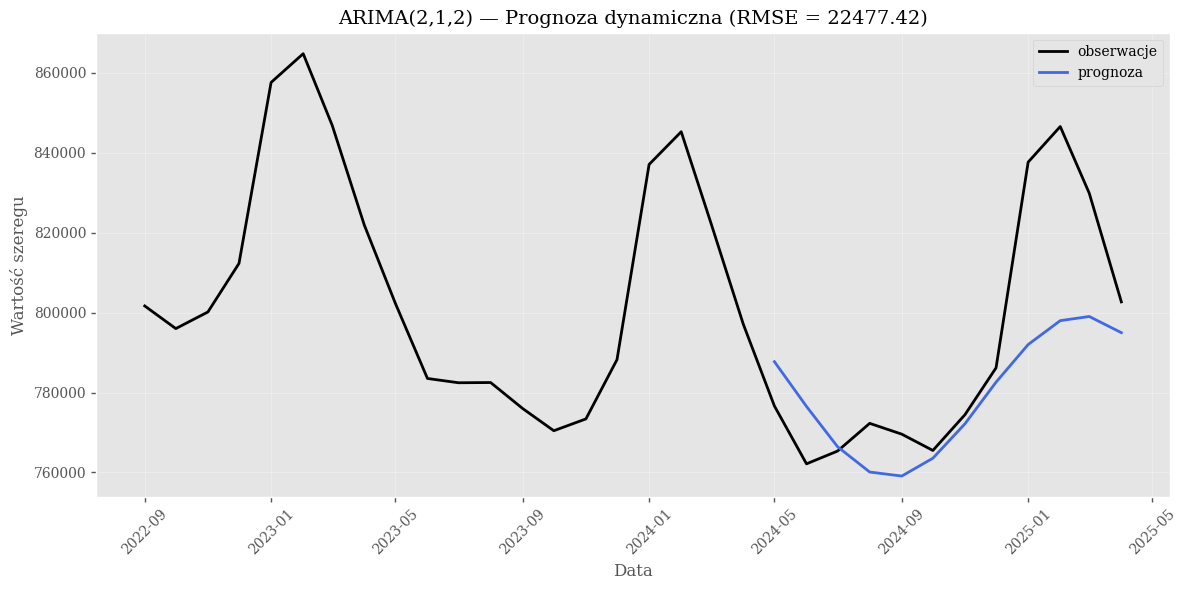

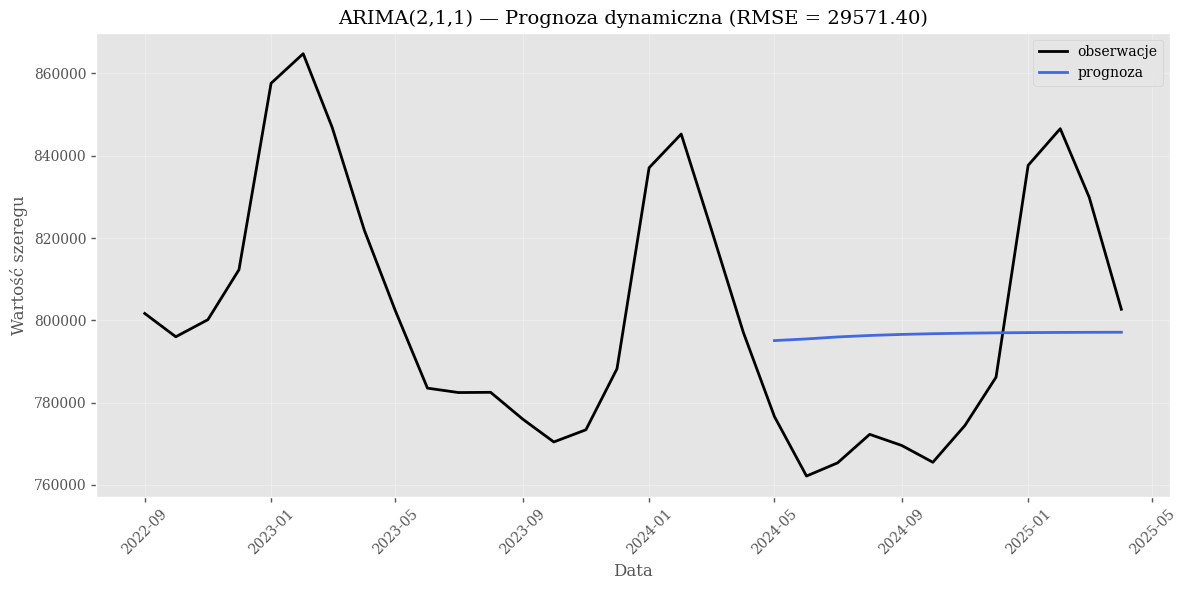

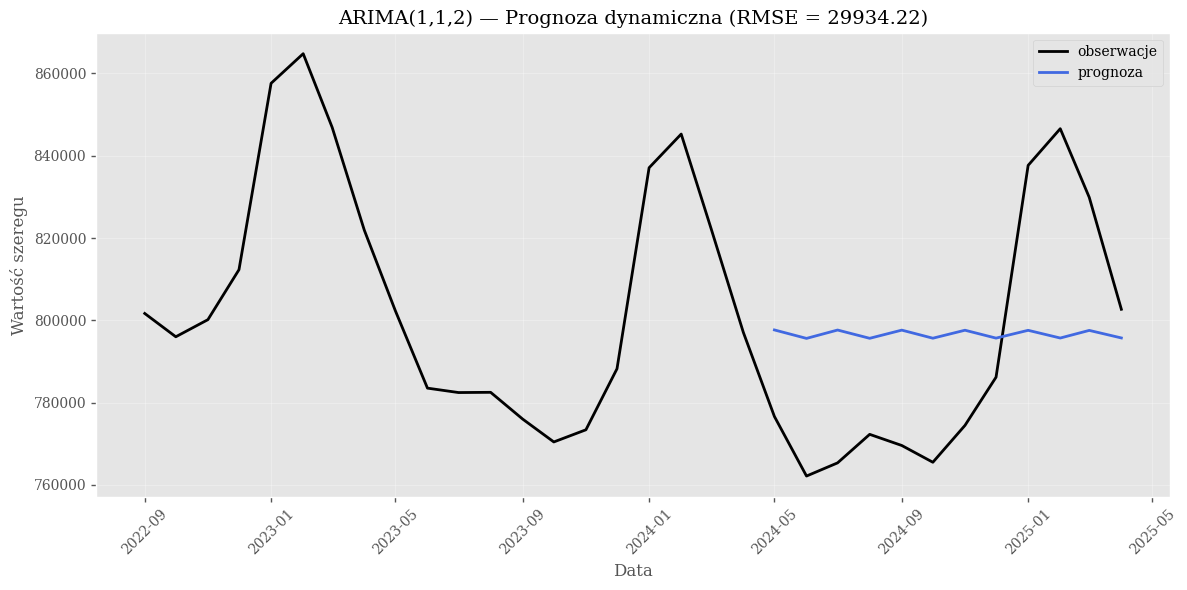

ARIMA(3,1,3) — MAE: 15851.14, RMSE: 22544.87


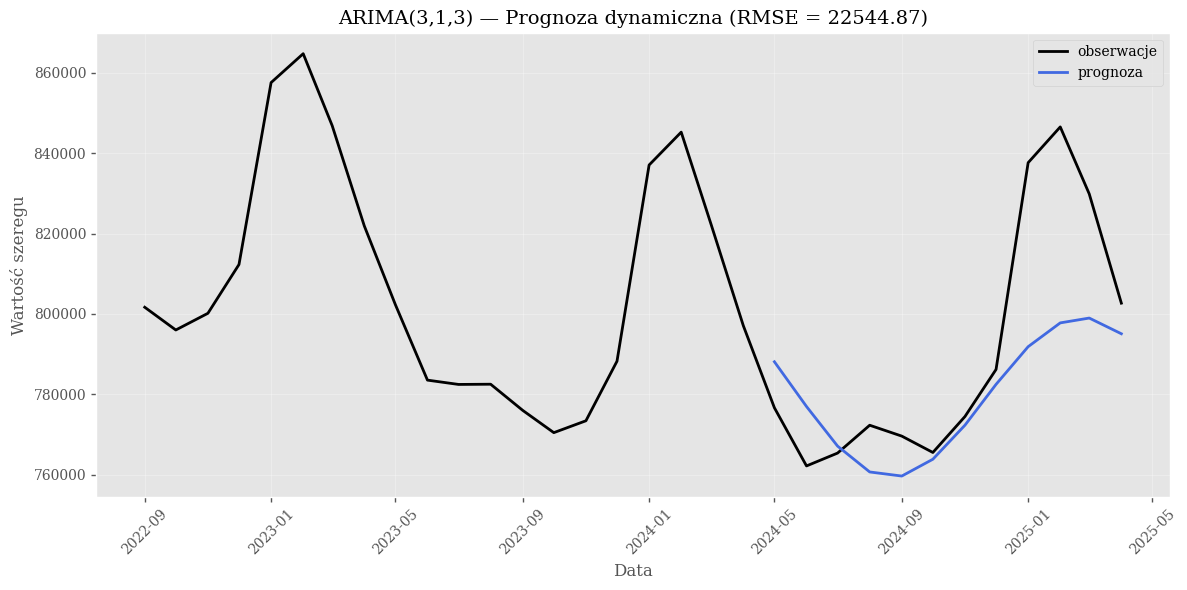

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prognoza na 12 miesięcy
forecast_horizon = 12
train, test = y[:-forecast_horizon], y[-forecast_horizon:]

# Konfiguracje modeli ARIMA
cfgs = {
    "ARIMA(2,1,2)": (2,1,2),
    "ARIMA(2,1,1)": (2,1,1),
    "ARIMA(1,1,2)": (1,1,2)
}

# Wyniki prognoz i metryk
results = {}
for name, order in cfgs.items():
    mdl = ARIMA(train, order=order).fit()
    fc = mdl.forecast(steps=len(test))
    mae = mean_absolute_error(test, fc)
    rmse = np.sqrt(mean_squared_error(test, fc))
    results[name] = (fc, mae, rmse)

# Benchmark: prognoza naiwna
naive_fc = np.repeat(train.iloc[-1], len(test))
mae_naive = mean_absolute_error(test, naive_fc)
rmse_naive = np.sqrt(mean_squared_error(test, naive_fc))
results["Naïve"] = (naive_fc, mae_naive, rmse_naive)

# Tabela błędów
tbl = pd.DataFrame({k: {"MAE": v[1], "RMSE": v[2]} for k, v in results.items()}).T
print(tbl.sort_values("RMSE"))

# WYKRESY: oddzielny wykres dla każdego modelu (bez benchmarku)
plt.style.use("ggplot")
for name in cfgs.keys():
    fc, mae, rmse = results[name]
    plt.figure(figsize=(12, 6))
    
    # Pokazujemy ostatnie 20 punktów treningowych + test
    full_plot = pd.concat([train[-20:], test])
    plt.plot(full_plot.index, full_plot, color="black", label="obserwacje", linewidth=2)
    
    # Prognoza danego modelu
    plt.plot(test.index, fc, color="royalblue", label="prognoza", linewidth=2)
    
    # Tytuł z metrykami
    plt.title(f"{name} — Prognoza dynamiczna (RMSE = {rmse:.2f})", fontsize=14)
    plt.xlabel("Data")
    plt.ylabel("Wartość szeregu")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === ARIMA(3,1,3) ===
order_313 = (3, 1, 3)
name_313 = "ARIMA(3,1,3)"

mdl_313 = ARIMA(train, order=order_313).fit()
fc_313 = mdl_313.forecast(steps=len(test))
mae_313 = mean_absolute_error(test, fc_313)
rmse_313 = np.sqrt(mean_squared_error(test, fc_313))

print(f"{name_313} — MAE: {mae_313:.2f}, RMSE: {rmse_313:.2f}")

# Wykres dla ARIMA(3,1,3)
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

full_plot = pd.concat([train[-20:], test])
plt.plot(full_plot.index, full_plot, color="black", label="obserwacje", linewidth=2)
plt.plot(test.index, fc_313, color="royalblue", label="prognoza", linewidth=2)

plt.title(f"{name_313} — Prognoza dynamiczna (RMSE = {rmse_313:.2f})", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Wartość szeregu")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



ARIMA(2,1,2) — MAE: 30302.84, RMSE: 34343.17


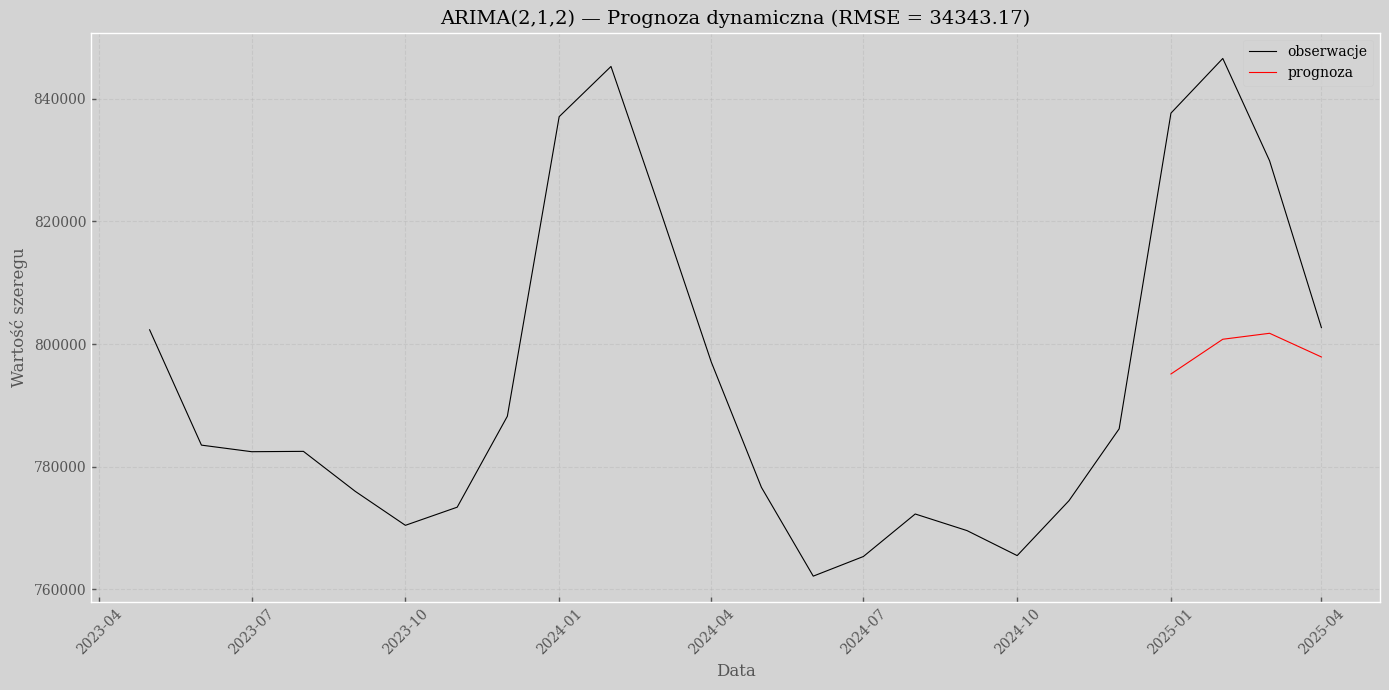

ARIMA(3,1,3) — MAE: 30260.20, RMSE: 34284.86


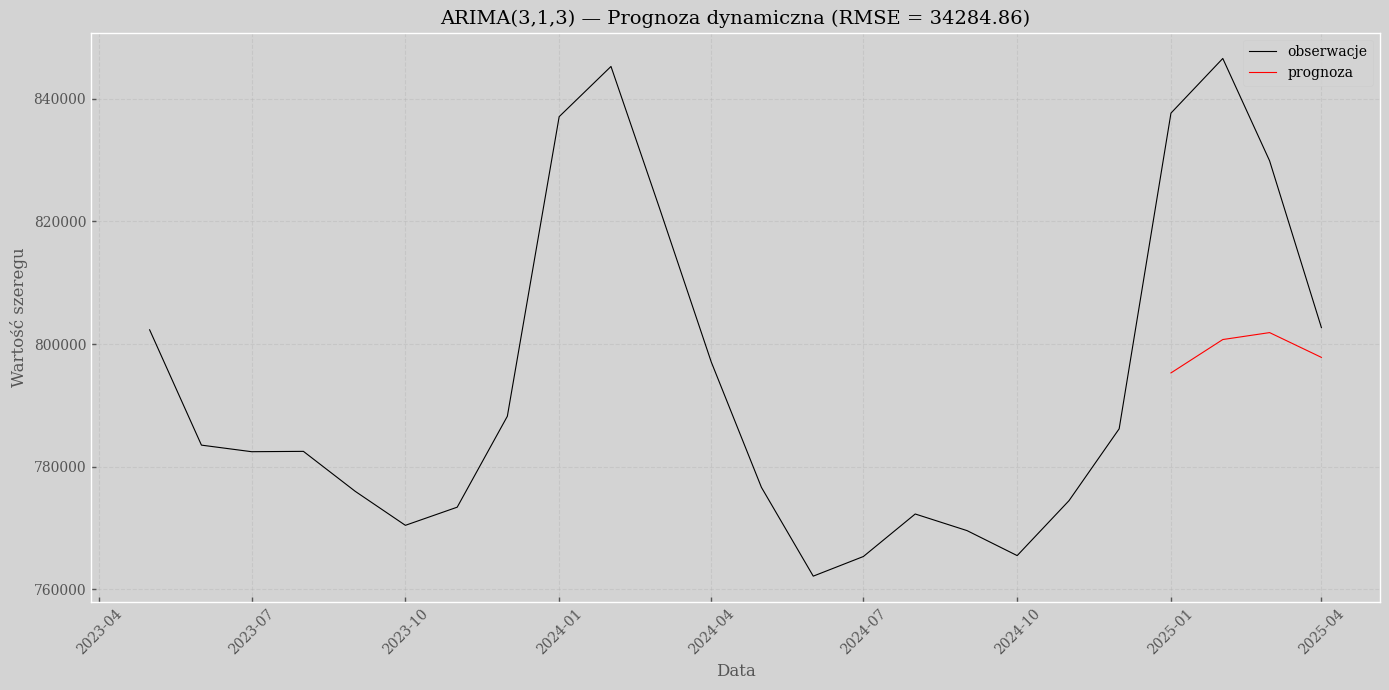

ARIMA(1,1,2) — MAE: 41273.76, RMSE: 44340.66


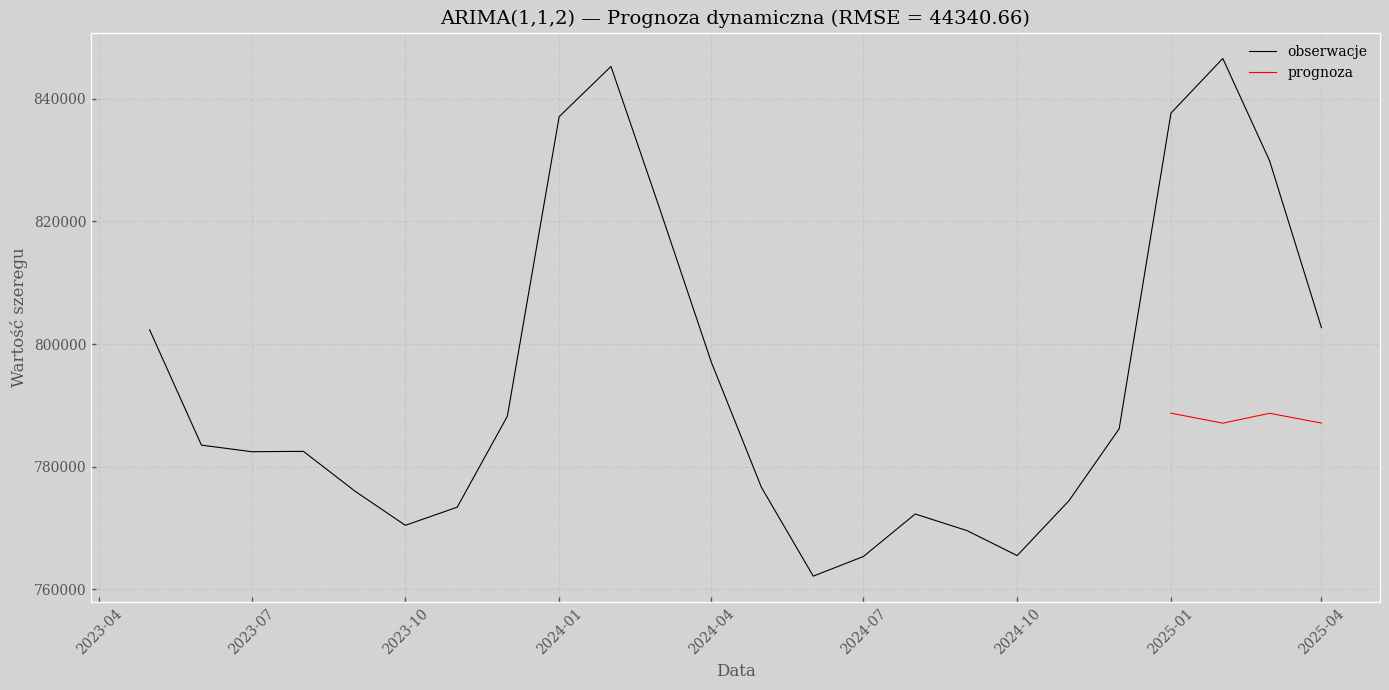

Wygładzenie wykładnicze — MAE: 43010.75, RMSE: 46032.90


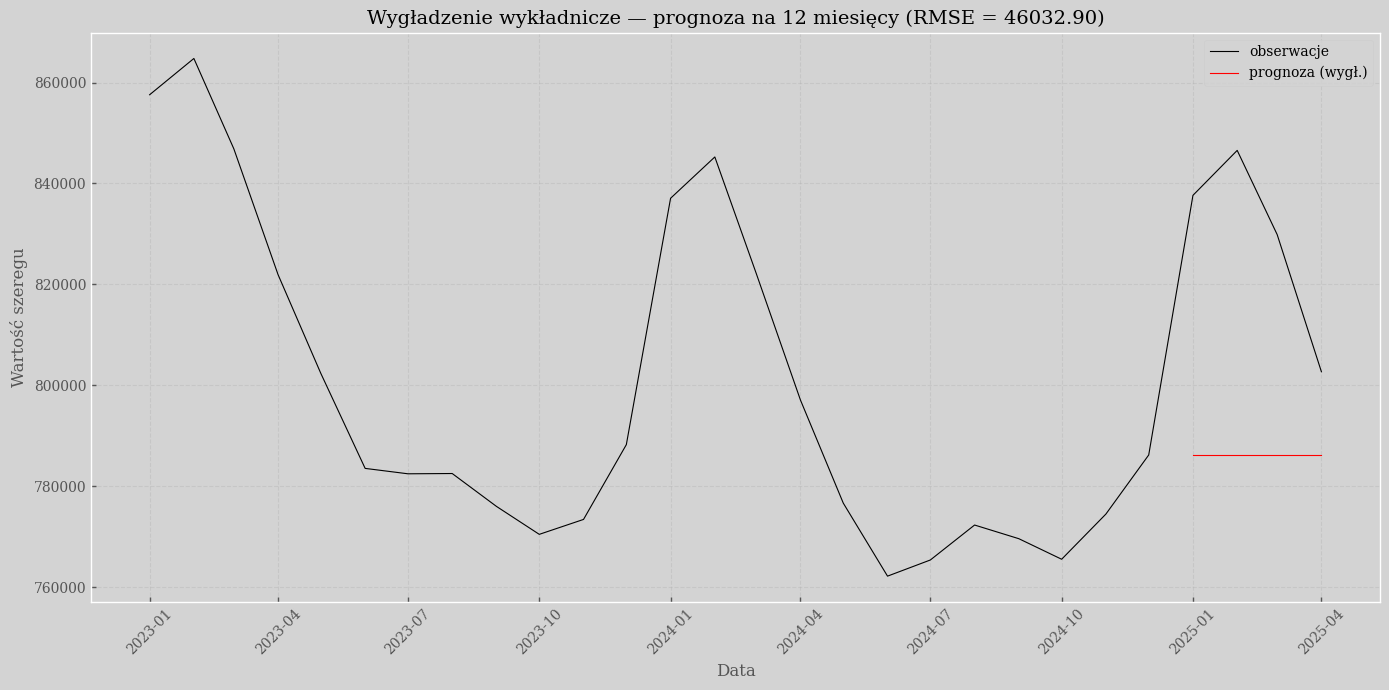

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Dane i ustawienia ---
forecast_horizon = 4
train, test = y[:-forecast_horizon], y[-forecast_horizon:]

# --- Lista modeli ---
models = {
    "ARIMA(2,1,2)": (2, 1, 2),
    "ARIMA(3,1,3)": (3, 1, 3),
    "ARIMA(1,1,2)": (1, 1, 2)
}

# --- Trenowanie, prognozowanie i wykresy ---
for name, order in models.items():
    # Trening modelu
    model = ARIMA(train, order=order).fit()
    forecast = model.forecast(steps=forecast_horizon)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    print(f"{name} — MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Przygotowanie wykresu
    plt.figure()
    full_plot = pd.concat([train[-20:], test])
    plt.plot(full_plot.index, full_plot, color="black", label="obserwacje")
    plt.plot(test.index, forecast, color="red", label="prognoza")
    
    plt.title(f"{name} — Prognoza dynamiczna (RMSE = {rmse:.2f})")
    plt.xlabel("Data")
    plt.ylabel("Wartość szeregu")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Model wygładzający — tylko poziom
model_smooth = ExponentialSmoothing(train, trend=None, seasonal=None).fit()
forecast_smooth = model_smooth.forecast(steps=forecast_horizon)

mae_smooth = mean_absolute_error(test, forecast_smooth)
rmse_smooth = np.sqrt(mean_squared_error(test, forecast_smooth))

print(f"Wygładzenie wykładnicze — MAE: {mae_smooth:.2f}, RMSE: {rmse_smooth:.2f}")

# Wykres
plt.figure()
full_plot = pd.concat([train[-24:], test])
plt.plot(full_plot.index, full_plot, color="black", label="obserwacje")
plt.plot(test.index, forecast_smooth, color="red", label="prognoza (wygł.)")
plt.title(f"Wygładzenie wykładnicze — prognoza na 12 miesięcy (RMSE = {rmse_smooth:.2f})")
plt.xlabel("Data")
plt.ylabel("Wartość szeregu")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


ARIMA(2,1,2) — MAE: 15811.82, RMSE: 22477.42


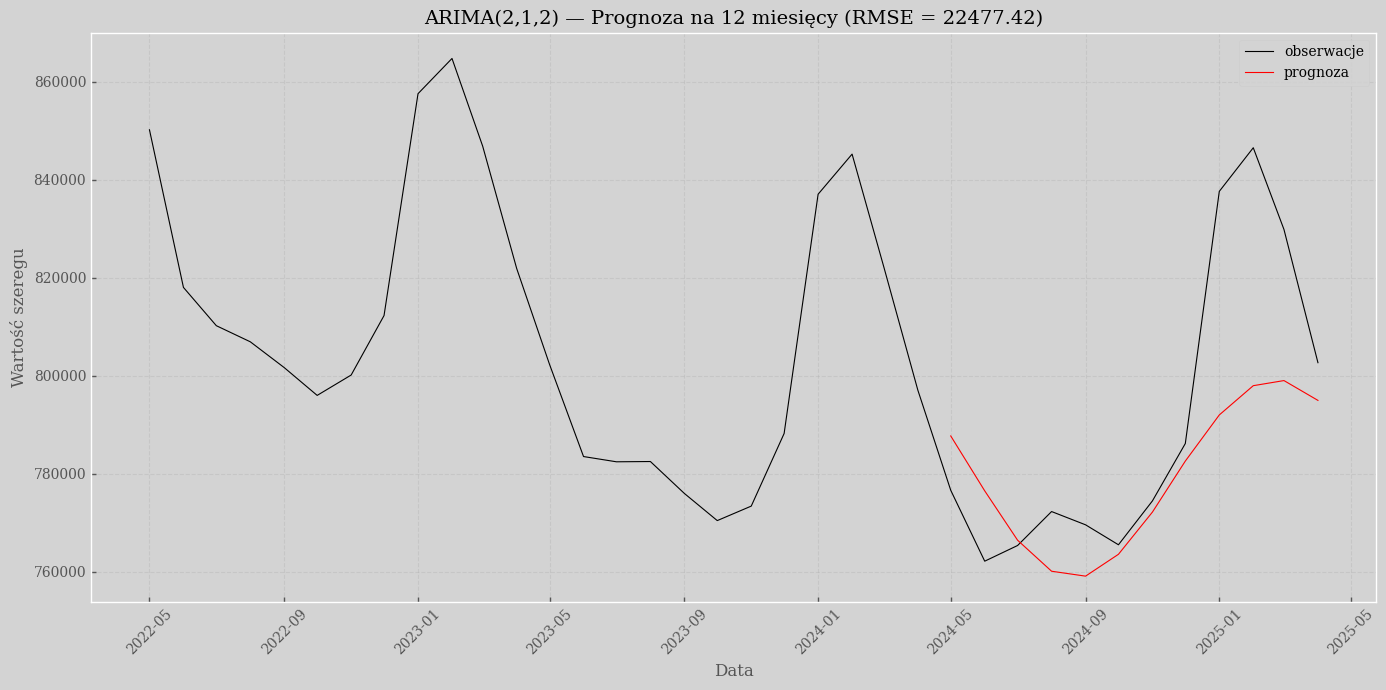

ARIMA(3,1,3) — MAE: 15851.14, RMSE: 22544.87


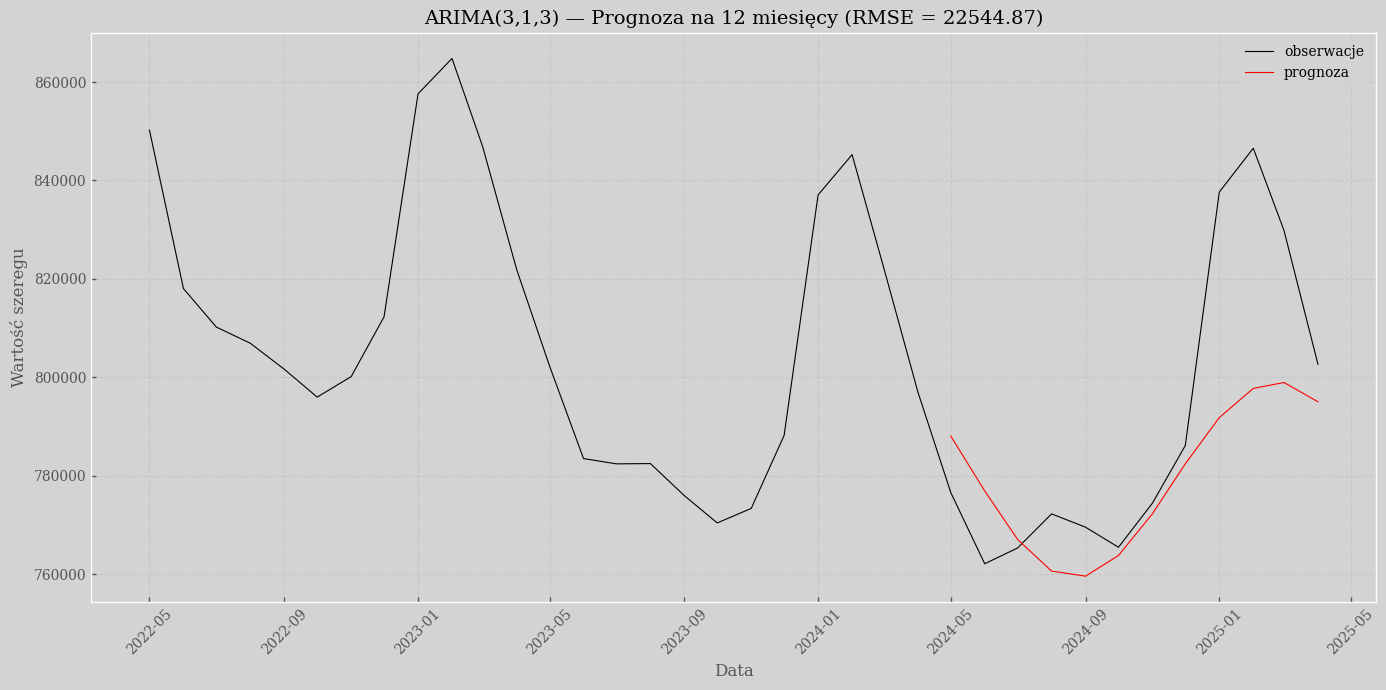

ARIMA(1,1,2) — MAE: 27592.07, RMSE: 29934.22


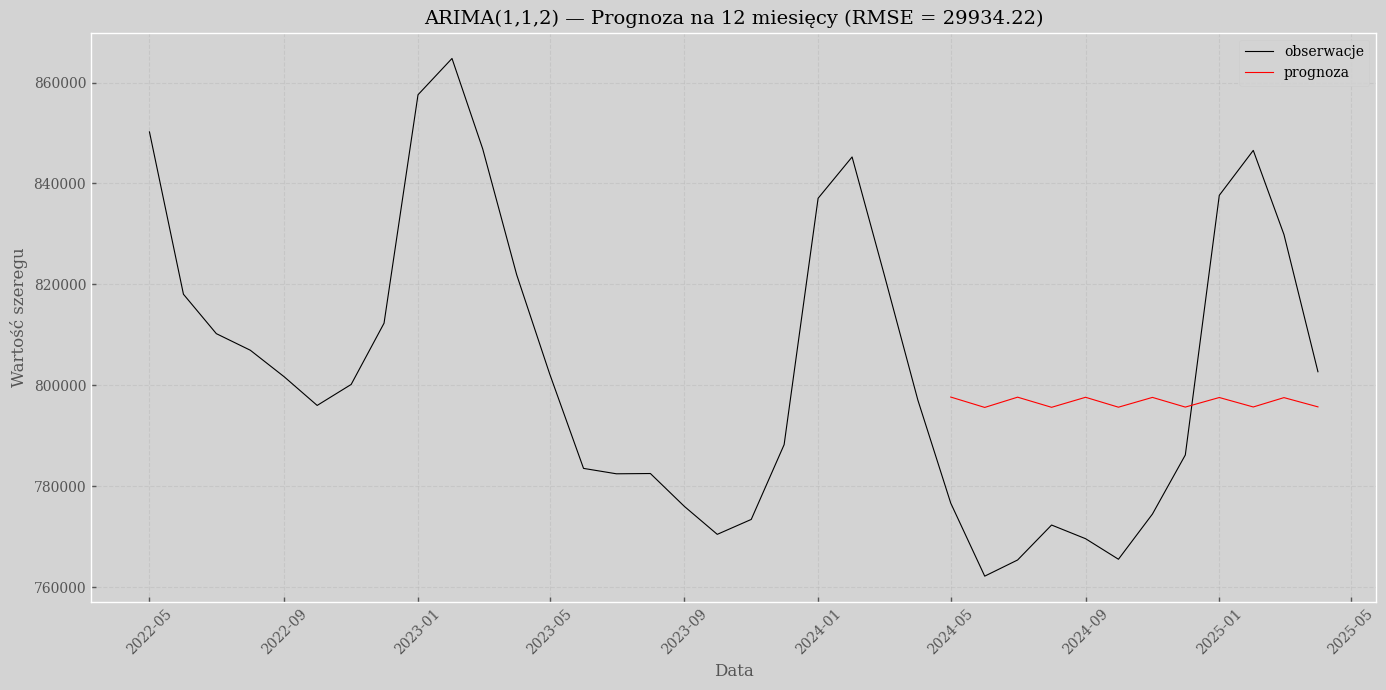

Wygładzenie wykładnicze — MAE: 27777.71, RMSE: 30080.75


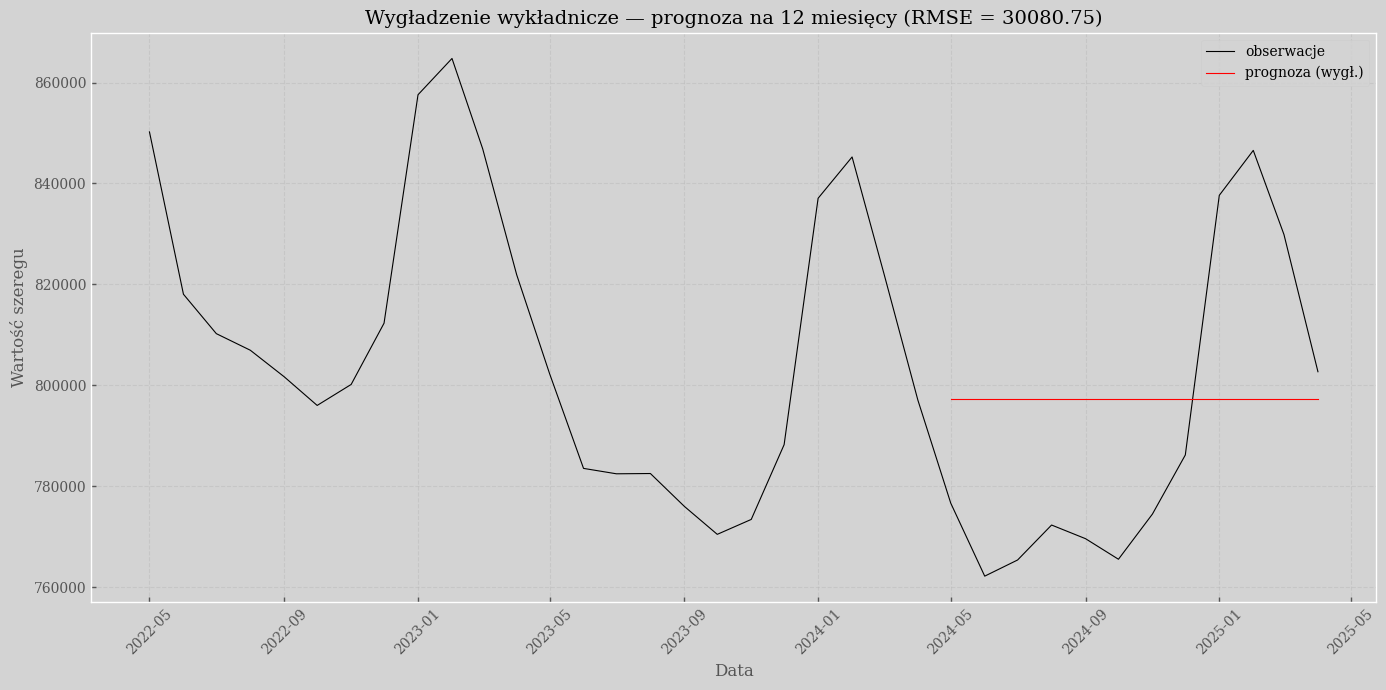

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Dane i ustawienia ---
forecast_horizon = 12
train, test = y[:-forecast_horizon], y[-forecast_horizon:]

# --- Lista modeli ---
models = {
    "ARIMA(2,1,2)": (2, 1, 2),
    "ARIMA(3,1,3)": (3, 1, 3),
    "ARIMA(1,1,2)": (1, 1, 2)
}

# --- Trenowanie, prognozowanie i wykresy ---
for name, order in models.items():
    model = ARIMA(train, order=order).fit()
    forecast = model.forecast(steps=forecast_horizon)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    print(f"{name} — MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Przygotowanie wykresu — ostatnie 24 miesięcy obserwacji
    plt.figure()
    full_plot = pd.concat([train[-24:], test])
    plt.plot(full_plot.index, full_plot, color="black", label="obserwacje")
    plt.plot(test.index, forecast, color="red", label="prognoza")
    
    plt.title(f"{name} — Prognoza na 12 miesięcy (RMSE = {rmse:.2f})")
    plt.xlabel("Data")
    plt.ylabel("Wartość szeregu")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Model wygładzający — tylko poziom
model_smooth = ExponentialSmoothing(train, trend=None, seasonal=None).fit()
forecast_smooth = model_smooth.forecast(steps=forecast_horizon)

mae_smooth = mean_absolute_error(test, forecast_smooth)
rmse_smooth = np.sqrt(mean_squared_error(test, forecast_smooth))

print(f"Wygładzenie wykładnicze — MAE: {mae_smooth:.2f}, RMSE: {rmse_smooth:.2f}")

# Wykres
plt.figure()
full_plot = pd.concat([train[-24:], test])
plt.plot(full_plot.index, full_plot, color="black", label="obserwacje")
plt.plot(test.index, forecast_smooth, color="red", label="prognoza (wygł.)")
plt.title(f"Wygładzenie wykładnicze — prognoza na 12 miesięcy (RMSE = {rmse_smooth:.2f})")
plt.xlabel("Data")
plt.ylabel("Wartość szeregu")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
from statsmodels.tsa.seasonal import STL

stl = STL(y, period=12).fit()
trend = stl.trend
season = stl.seasonal
resid = stl.resid


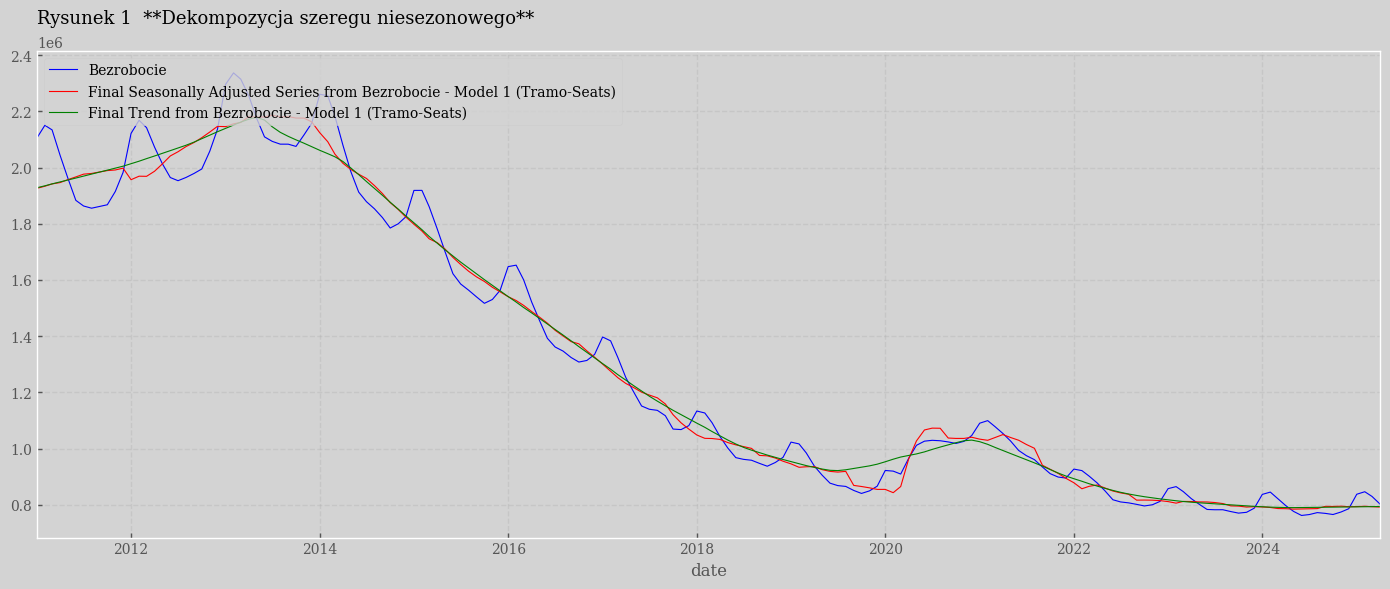

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# --- Dane ---
file_path = "bezrobocie_czasowe.xlsx"
df = pd.read_excel(file_path)

# Przygotowanie serii
if 'Data' in df.columns:
    df['Data'] = pd.to_datetime(df['Data'])
    y = df.set_index('Data')["Wartosc"].dropna()
    y = y.asfreq('MS')  # Miesięczna częstotliwość
else:
    y = df["Wartosc"].dropna()

# --- STL dekompozycja ---
stl = STL(y, period=12, robust=True).fit()
trend = stl.trend
seasonal = stl.seasonal
y_sa = y - seasonal  # Sezonowo oczyszczony

# --- Wykres w stylu Demetry ---
plt.figure(figsize=(14, 6))

plt.plot(y.index, y, color='blue', label='Bezrobocie')
plt.plot(y.index, y_sa, color='red', label='Final Seasonally Adjusted Series from Bezrobocie - Model 1 (Tramo-Seats)')
plt.plot(y.index, trend, color='green', label='Final Trend from Bezrobocie - Model 1 (Tramo-Seats)')

plt.grid(True, which='major', linewidth=1.0)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.title("Rysunek 1  **Dekompozycja szeregu niesezonowego**", fontsize=13, loc='left', pad=20)
plt.xlabel("date")
plt.xlim(y.index.min(), y.index.max())

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
